The mocks appear to not have any issues with the cosmology analyses, but the data does.  What is the difference?

In [1]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

# Mock

Read in one of the mocks that Segev has put together.

In [2]:
mock_directory = '/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/'
mock_version = 'v0.5.4'
mock_filename = 'TF_AbacusSummit_base_c000_ph000_r001_z0.11.fits'

hdul = fits.open(mock_directory + mock_version + '/' + mock_filename)
mock = Table(hdul[1].data)
hdul.close()

In [3]:
mock[:5]

RA,DEC,ZOBS,ZCOS,vx,vy,vz,DWARF,MAIN,LOGVROT,R_ABSMAG_SB26,LOGDIST_TRUE,LOGDIST,LOGDIST_ERR,Y1_COMP,Y3_COMP
float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64
185.7022102832178,4.1413601223312755,0.11172798555016938,0.10991454536005436,-423.27459716796875,-520.94970703125,250.795166015625,False,True,2.3420067443057624,-21.95743584272125,0.007618177987605179,-0.03542920254414526,0.11396312082005429,1.0,1.0
180.42242370187515,-1.0065998873875552,0.11009305112079626,0.10870194561286645,-370.06585693359375,-10.584589958190918,-345.9512634277344,False,True,2.353408355391376,-21.88555843959148,0.0059156701494544,-0.06697621486805616,0.11372692990252656,1.0,1.0
176.48050201097269,6.728829453440869,0.11136099673967004,0.10971141393698831,-508.4543762207031,49.60839080810547,-523.8817749023438,False,True,2.2037829202552524,-21.175679573158202,0.0069466571333791196,0.016393174293638426,0.11337535428375785,0.0,0.9636363636363636
186.43150214255164,5.600938272383595,0.11122607861529477,0.1093812948143913,-502.3745422363281,-484.9122619628906,-536.5270385742188,False,True,2.3246492632802416,-21.755657280895946,0.007784166202758059,-0.04964347459973198,0.1141191376202486,0.0,0.9556962025316456
189.67425955028784,3.0100353751287936,0.11095549988278042,0.10975353968612903,-471.7829895019531,805.4813842773438,-86.82174682617188,False,False,2.4892584303168723,-21.808558152451642,0.005069468681499246,-0.2869748900033415,0.11426032747158157,0.9867549668874173,0.9536423841059603


# Binned histogram function

In [4]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

# $\eta$ v. z

/tmp/ipykernel_1832394/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1832394/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


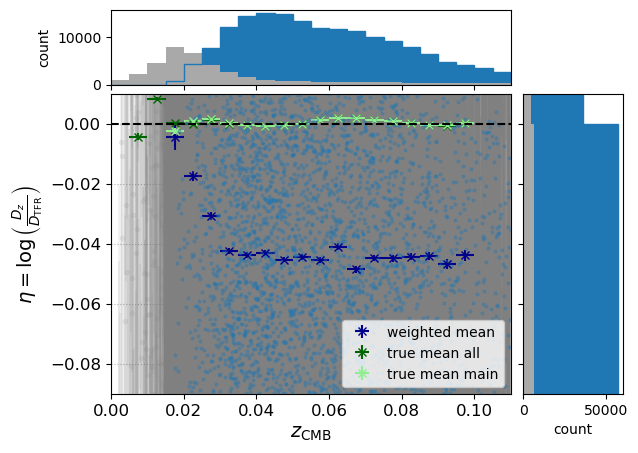

In [6]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = mock['MAIN']
sample2 = ~mock['MAIN']

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(mock['ZOBS'][sample2][::20], 
            mock['LOGDIST'][sample2][::20], 
            yerr=mock['LOGDIST_ERR'][sample2][::20],
            fmt='.', 
            color='gray',
            alpha=0.1, 
            ecolor='gray')

ax.errorbar(mock['ZOBS'][sample1][::20], 
            mock['LOGDIST'][sample1][::20], 
            yerr=mock['LOGDIST_ERR'][sample1][::20],
            fmt='.', 
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(mock['ZOBS'][sample1], 
                                    mock['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=mock['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', 
            color='darkblue', 
            label='weighted mean')

# Plot the mean of the true logdist values
N, y_avg, y_std = profile_histogram(mock['ZOBS'],#[sample1], 
                                    mock['LOGDIST_TRUE'],#[sample1], 
                                    zbins)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', 
            color='darkgreen', 
            label='true mean all')

N, y_avg, y_std = profile_histogram(mock['ZOBS'][sample1], 
                                    mock['LOGDIST_TRUE'][sample1], 
                                    zbins)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', 
            color='lightgreen', 
            label='true mean main')

# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend(loc='lower right')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
# ax.set_xlim((0, 0.105))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.09, 0.01))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(mock['ZOBS'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(mock['ZOBS'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(mock['ZOBS'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(mock['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(mock['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(mock['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');